In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import svm, datasets
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
#------------------------------------------------------------------------------
# 1- Split into a training set and a test set using a ShuffleSplit
#    + doing that in parallel for the differrent features to test
#------------------------------------------------------------------------------

from sklearn.model_selection import ShuffleSplit
def split_data(X, y, test_size=.25, train_size=None) :
    

    rs = ShuffleSplit(n_splits=1, test_size=test_size, train_size=train_size, random_state=0)
    for index_train, index_test in rs.split(y): pass

    X_train, X_test = {}, {}
    X_train, X_test = X[index_train, :], X[index_test, :]
    y_train, y_test =  y[index_train].copy(), y[index_test].copy()

    print('nb_trial_train : %s, nb_trial_test : %s'%(y_train.shape[0], y_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [3]:
 #------------------------------------------------------------------------------
# 4- Train a SVM classification model
#------------------------------------------------------------------------------

# When training an SVM with the Radial Basis Function (RBF) kernel,
#    two parameters must be considered: C and gamma.

#The parameter C, common to all SVM kernels, trades off misclassification
#of training examples against simplicity of the decision surface.
#    A low C makes the decision surface smooth,
#    while a high C aims at classifying all training examples correctly.

#gamma defines how much influence a single training example has.
#    The larger gamma is, the closer other examples must be to be affected.


from sklearn.grid_search import GridSearchCV # see http://scikit-learn.org/stable/modules/grid_search.html
from sklearn.svm import SVC


def Train_SVM(X_train, y_train) :

    a=32
    C_range = np.logspace(-5, 10., a, base=2.)
    gamma_range = np.logspace(-14, 3, a, base=2.)

    

    param_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': gamma_range, 'C': C_range},
                  {'kernel': ['linear'], 'C': C_range}]

    
    grid = GridSearchCV(SVC(verbose=False, tol=1e-3, max_iter = -1, ),
                        param_grid, verbose=1, scoring='f1_weighted', n_jobs=1,) #cv=50, 

    X_train_ = np.zeros((len(X_train), 0))
    X_train_ = np.hstack((X_train_, X_train))
    grid.fit(X_train, y_train.ravel())


    # plot the scores of the grid
    score_dict = grid.grid_scores_ # grid_scores_ contains parameter settings and scores
    
    scores_mean, scores_std ={}, {}
    for params, mean_score, scores in score_dict:
        try :
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)
        except:
            scores_mean[params['kernel']] = []
            scores_std[params['kernel']] = []
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)


    # draw heatmap of accuracy as a function of gamma and C
    fig1, ax1 = plt.subplots(1,4,figsize=(5*4,5))

    
    for x, k in enumerate(['rbf', 'poly', 'sigmoid']) :
        scores = np.array(scores_mean[k]).reshape((gamma_range.shape[0], C_range.shape[0]))
        im = ax1[x].imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
        ax1[x].set_xlabel('gamma')
        ax1[x].set_ylabel('C')
        #ax.set_colorbar()
        ax1[x].set_title(k)
        fig1.colorbar(im, ax=ax1[x], pad=0.01, fraction=.047)
    
    scores = np.array(scores_mean['linear']) #.reshape((gamma_range.shape[0], C_range.shape[0]))
    #im = ax1.imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
    
    ax1[-1].set_title('linear')
    ax1[-1].plot(C_range, scores, 'k')
    ax1[-1].set_xlabel('C')
    ax1[-1].set_ylabel('Score')
    
    fig1.tight_layout()
    plt.show()
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    return grid

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
#------------------------------------------------------------------------------
# 5- Quantitative evaluation of the model quality on the test set
#------------------------------------------------------------------------------
def Quantitative_evaluation(grid, X_test, classes) :

    import itertools
    from sklearn import metrics
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    
    y_pred = grid.predict(X_test)
    # see https://en.wikipedia.org/wiki/F1_score
    fone_score = np.array(metrics.f1_score(y_test, y_pred, average=None)).mean()
    
    print("Predicting the category names on the testing set")
    print('\nclassification_report on test \n', classification_report(y_test, y_pred, target_names=classes))
    
    
    cm = confusion_matrix(y_test, y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    im = ax.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Reds)
    
    ax.set_title('Confusion matrix\n(fone_score on test => Accuracy = %0.2f)' % (fone_score))
    fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = norm_cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 'nb_trial = %s\n\n(%.0f %%)'%(cm[i, j], norm_cm[i, j]*100),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        if i==j :
            ax.text(j, i+0.2, 'f1_score = %.2f'%(metrics.f1_score(y_test, y_pred, average=None)[i]),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    return y_pred

In [5]:
from sklearn import metrics

def fig_final(grid, X_train, y_train, X_test, y_test, y_pred) :
    
    #nb = int((X_train.shape[1]-1)*(X_train.shape[1]-(X_train.shape[1]/2)))
    
    #fig, ax = plt.subplots(1,nb,figsize=(10*(nb),10/1.68))

    #x = 0
    for x1 in range(X_train.shape[1]) :

        nb = len(range(x1, X_train.shape[1]-1))
        fig, axs = plt.subplots(1,nb,figsize=(10*(nb),10/1.68))
        
        x=0
        for x2 in range(x1, X_train.shape[1]) :
            if x2 != x1 :
                
                if nb==1: ax = axs
                else : ax =axs[x]
                
                xlim = [min(X_train[:, x1]), max(X_train[:, x1])]
                ylim = [min(X_train[:, x2]), max(X_train[:, x2])]
                
                # create grid to evaluate model
                a = 1
                xx = np.linspace(xlim[0]-a, xlim[1]+a, len(X_train[:, x1]))
                yy = np.linspace(ylim[0]-a, ylim[1]+a, len(X_train[:, x2]))
                YY, XX = np.meshgrid(yy, xx)
                xy = np.vstack([XX.ravel(), YY.ravel()]).T

                clf = SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'],
                          gamma=grid.best_params_['gamma'])
                
                X_fit = [[],[]]
                X_fit[0], X_fit[1] = X_train[:, x1], X_train[:, x2]
                X_fit = np.array(X_fit).transpose()
                
                clf.fit(X_fit, y_train)
                Z = clf.decision_function(xy).reshape(XX.shape)



                # plot decision boundary and margins
                ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1, linestyles=['--', '-', '--'])
                ax.contourf(XX, YY, Z, cmap=plt.cm.RdGy, alpha=0.5)

                # plot support vectors
                ax.scatter(X_train[:, x1], X_train[:, x2], c=y_train, s=200, cmap=plt.cm.RdGy, alpha=0.3)
                #ax[x].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=150, linewidth=1, facecolors='none', edgecolors='k')

                #X_test_2d = X_test[:, x_:x_+2]:
                
                X_t = [[],[]]
                X_t[0], X_t[1] = X_test[:, x1], X_test[:, x2]
                X_t = np.array(X_t).transpose()
                y_pred2 = clf.predict(X_t)

                print('X_%s-X_%s'%(x1, x2), '\tscore grid :', clf.score(X_t, y_pred), '\tscore clf :',
                      clf.score(X_t, y_pred2))
                print('\t\tf1_score grid: \t%.2f'%np.array(metrics.f1_score(y_test, y_pred, average=None)).mean(),
                      '\tf1_score clf: %.2f'%np.array(metrics.f1_score(y_test, y_pred2, average=None)).mean(),
                     end='\n\n')


                ax.scatter(X_test[:, x1], X_test[:, x2], c=y_pred, s=40, cmap=plt.cm.RdGy)

                for a in range(len(y_test)) :
                    if y_test[a]!=y_pred[a] :
                        if y_test[a] == 1 : c='k'
                        else : c='r'
                        ax.scatter(X_test[a, x1], X_test[a, x2], facecolors='none', s=60, lw=2,
                                   edgecolors=c)

                ax.set_xlabel('X_%s'%x1)
                ax.set_ylabel('X_%s'%(x2))
                x=x+1

        plt.show()

In [6]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[iris.target>0]
y = iris.target[iris.target>0]
y -=1

classes = iris.target_names[1:]

In [7]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=.4, train_size=None)

nb_trial_train : 60, nb_trial_test : 40


Fitting 3 folds for each of 3104 candidates, totalling 9312 fits


[Parallel(n_jobs=1)]: Done 9312 out of 9312 | elapsed:   24.9s finished


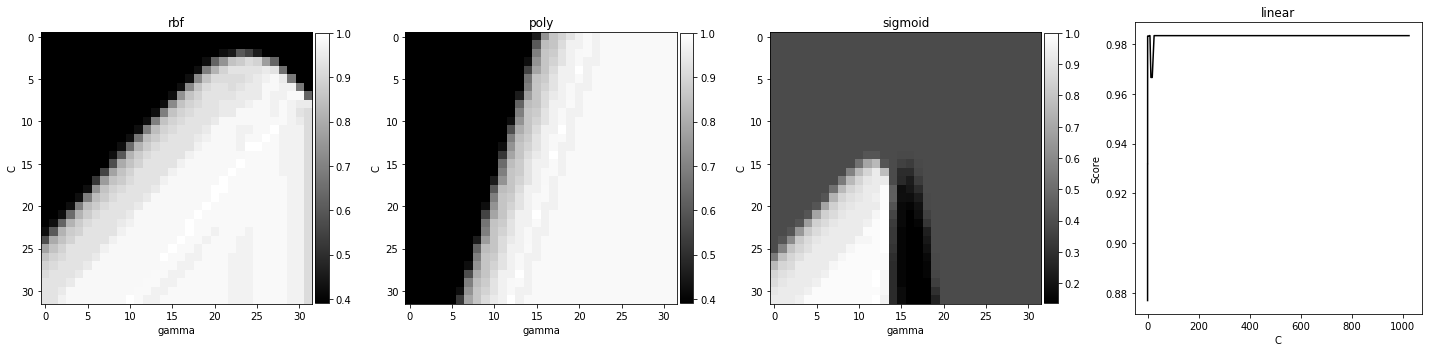

The best parameters are {'kernel': 'poly', 'gamma': 0.12223606704192902, 'C': 0.11953324868703187} with a score of 1.00


In [8]:
grid = Train_SVM(X_train, y_train)

Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

 versicolor       0.93      0.82      0.87        17
  virginica       0.88      0.96      0.92        23

avg / total       0.90      0.90      0.90        40



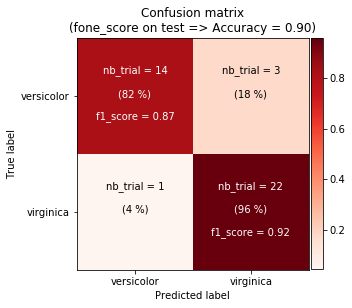

In [9]:
y_pred = Quantitative_evaluation(grid, X_test, classes)

X_0-X_1 	score grid : 0.625 	score clf : 1.0
		f1_score grid: 	0.90 	f1_score clf: 0.62

X_0-X_2 	score grid : 0.95 	score clf : 1.0
		f1_score grid: 	0.90 	f1_score clf: 0.84

X_0-X_3 	score grid : 0.9 	score clf : 1.0
		f1_score grid: 	0.90 	f1_score clf: 0.90



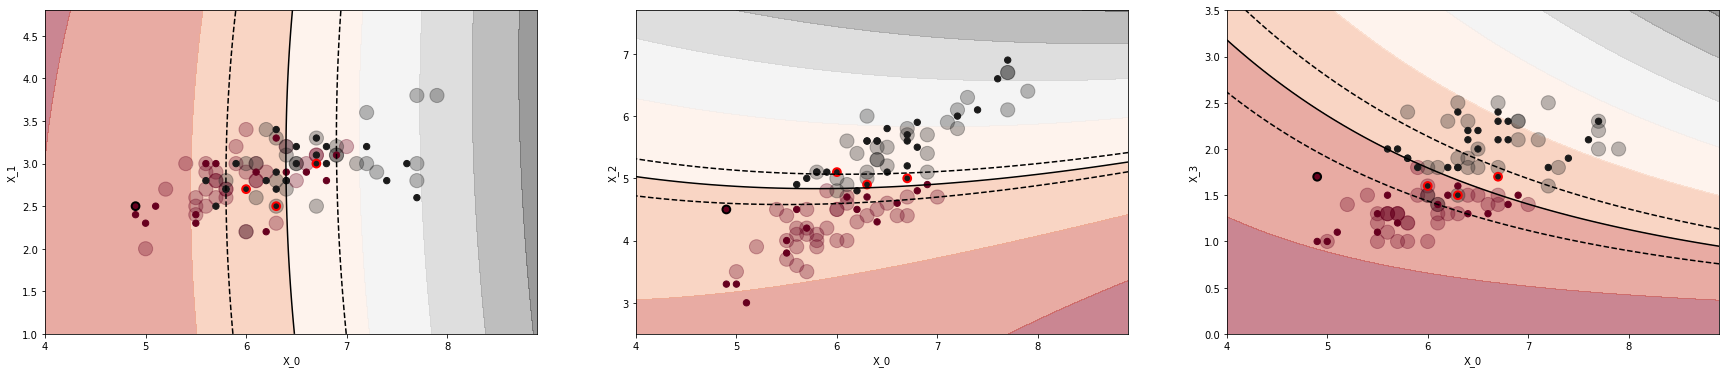

X_1-X_2 	score grid : 0.95 	score clf : 1.0
		f1_score grid: 	0.90 	f1_score clf: 0.84

X_1-X_3 	score grid : 0.725 	score clf : 1.0
		f1_score grid: 	0.90 	f1_score clf: 0.77



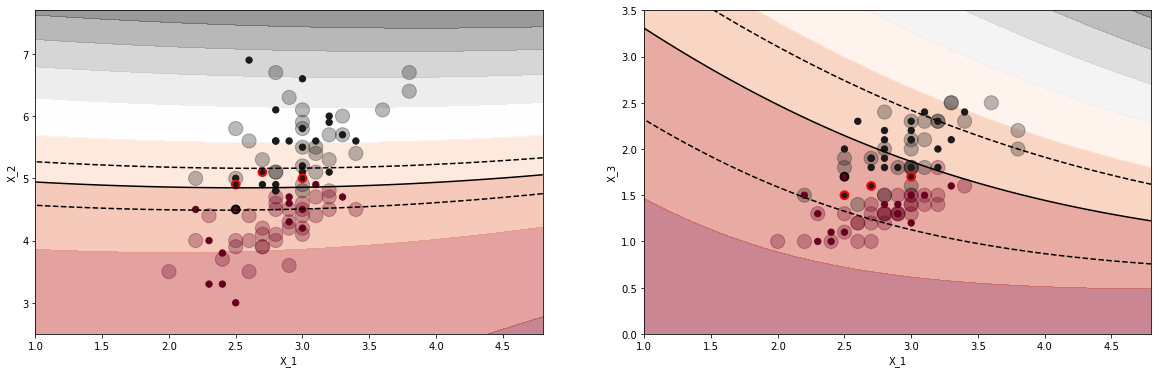

X_2-X_3 	score grid : 0.95 	score clf : 1.0
		f1_score grid: 	0.90 	f1_score clf: 0.90



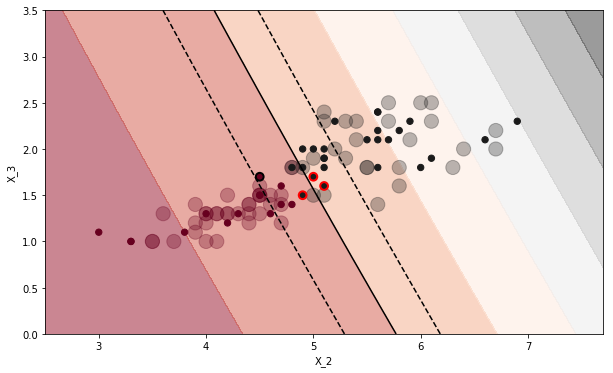

<Figure size 0x428.571 with 0 Axes>

In [10]:
fig_final(grid, X_train, y_train, X_test, y_test, y_pred) 